# Unit cost-benefit

### Imports

In [1]:
import pandas as pd
import plotnine as p9

## Data cleaning

In [2]:
data = {}

## Tier base-stats
for i in range(5): # 5 tiers
    data[f"tier_{i + 1}"] = pd.read_excel("data/2021-12-29_DespotsGame_UnitStats.xlsx", sheet_name=i).dropna(axis="columns", how="all").fillna(0)

## Bonus stats per level
data["bonus"] = pd.read_excel("data/2021-12-29_DespotsGame_UnitStats.xlsx", sheet_name=i + 1).dropna(axis="columns").fillna(0)

In [3]:
data["tier_3"]

,Level_3,Tank,Fencer,Trickster,Figther,Healer,Thrower,Shooter,Cultist,Mage,Egghead
0,attack_dmg,58.0,100.0,180.0,80.0,10.0,140.0,75.0,120.0,180.0,74.0
1,attack_spd,0.0,0.0,40.0,30.0,0.0,40.0,0.0,20.0,0.0,0.0
2,armor,35.0,10.0,16.0,20.0,7.0,0.0,0.0,13.0,12.0,12.0
3,health,430.0,310.0,230.0,390.0,90.0,150.0,70.0,210.0,60.0,210.0
4,mana,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0
5,movement,0.0,20.0,20.0,30.0,20.0,20.0,20.0,20.0,20.0,-10.0
6,range,0.0,0.0,1.5,0.0,3.0,4.0,10.0,5.0,12.0,6.0
7,cost,15.0,12.0,17.0,13.0,11.0,19.0,15.0,18.0,17.0,17.0


In [4]:
data["bonus"]

,Tier,Class,Variable,Bonus_pct
0,1,Tank,attack_dmg,3
1,1,Tank,health,3
2,2,Tank,attack_dmg,4
3,2,Tank,health,5
4,3,Tank,attack_dmg,3
...,...,...,...,...
75,3,Egghead,health,10
76,4,Egghead,attack_dmg,4
77,4,Egghead,health,10
78,5,Egghead,attack_dmg,5


In [5]:

def tidy_melt(data : dict, tier : int):    

    dframe = data[f"tier_{tier}"]
    level_name = f"Level_{tier}"

    dframe_melt = pd.melt(dframe, id_vars = [f"Level_{tier}"], var_name="Class").rename(columns = {level_name : "Variable"}).assign(Tier = tier)
    dframe_melt= pd.merge(dframe_melt, data["bonus"], on= [ "Tier", "Class", "Variable" ], how="left" ).fillna(0)

    return dframe_melt

In [6]:
dframe_stats = pd.concat( [ tidy_melt(data, tier=i) for i in range(1,6) ] )
dframe_stats.sample(10)

,Variable,Class,value,Tier,Bonus_pct
49,attack_spd,Shooter,0.0,1,0.0
50,armor,Shooter,0.0,2,0.0
40,attack_dmg,Thrower,140.0,3,0.0
68,mana,Mage,0.0,3,0.0
77,movement,Egghead,-10.0,1,0.0
68,mana,Mage,0.0,5,0.0
58,armor,Cultist,13.0,2,0.0
56,attack_dmg,Cultist,200.0,5,0.0
59,health,Cultist,70.0,1,0.0
49,attack_spd,Shooter,0.0,5,0.0


## Visualization

## Growth per class tier

In this plot we can see which unit statistic increases over tiers.

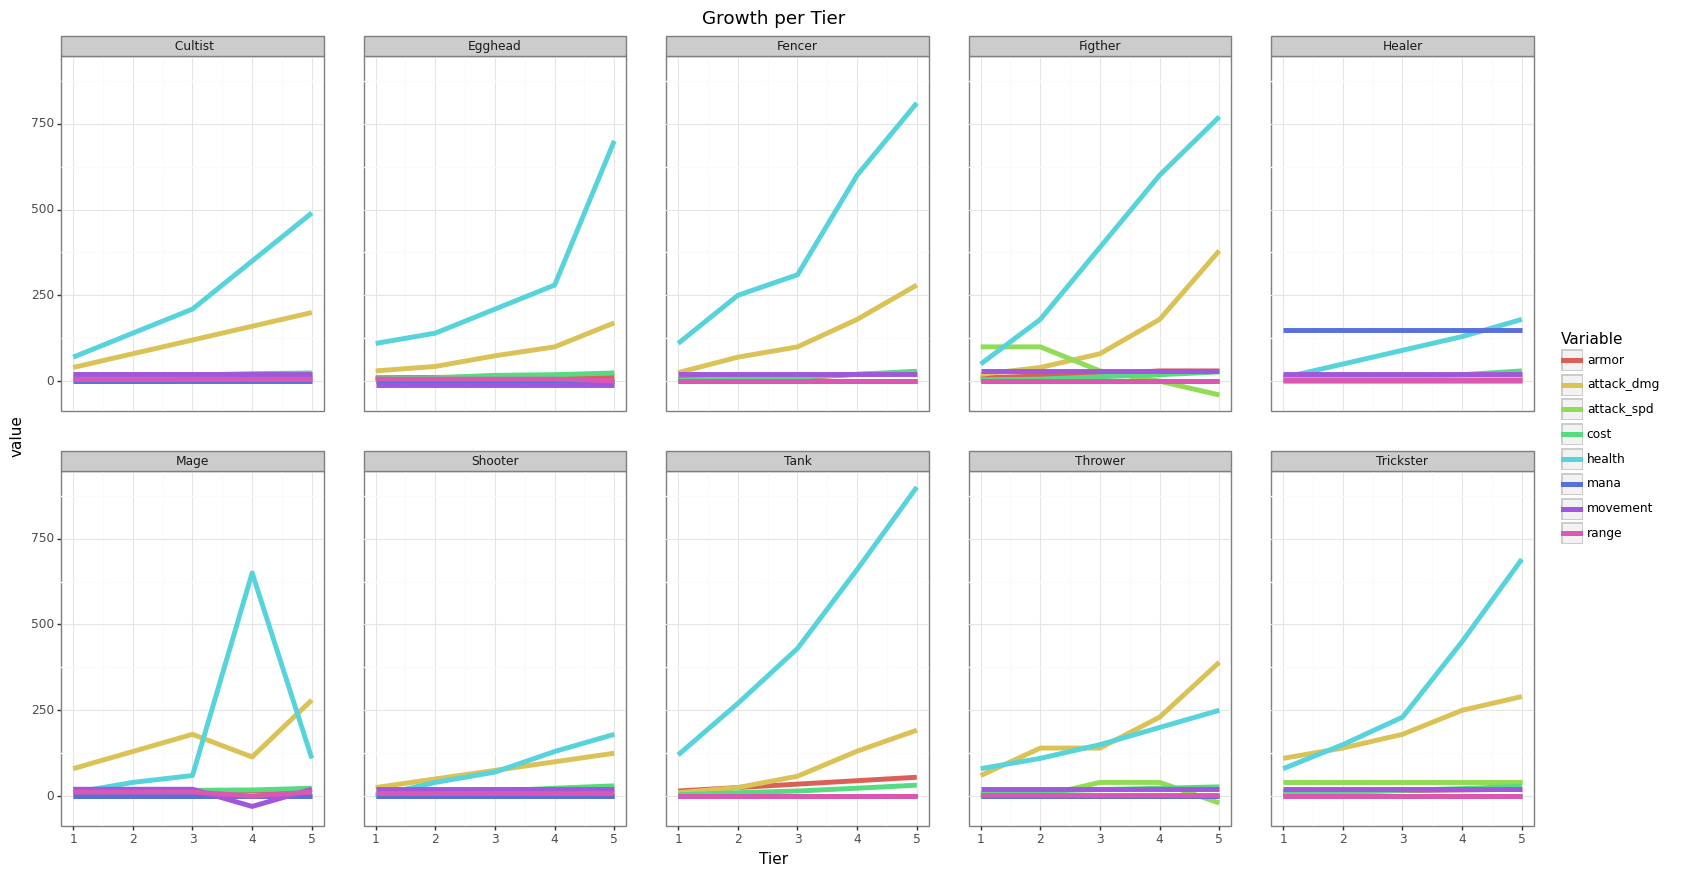

<ggplot: (8790451706670)>

In [26]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_stats) + 
 p9.aes(x = "Tier", y = "value", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", nrow=2) +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Growth per Tier")
)

display(gg_unit_trend)

#### On a log-scale

Because some stats are negative, the scale of stats was slided down so that the minimum value is 0.01, otherwise the trendlines wouldn't be able to render.

/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


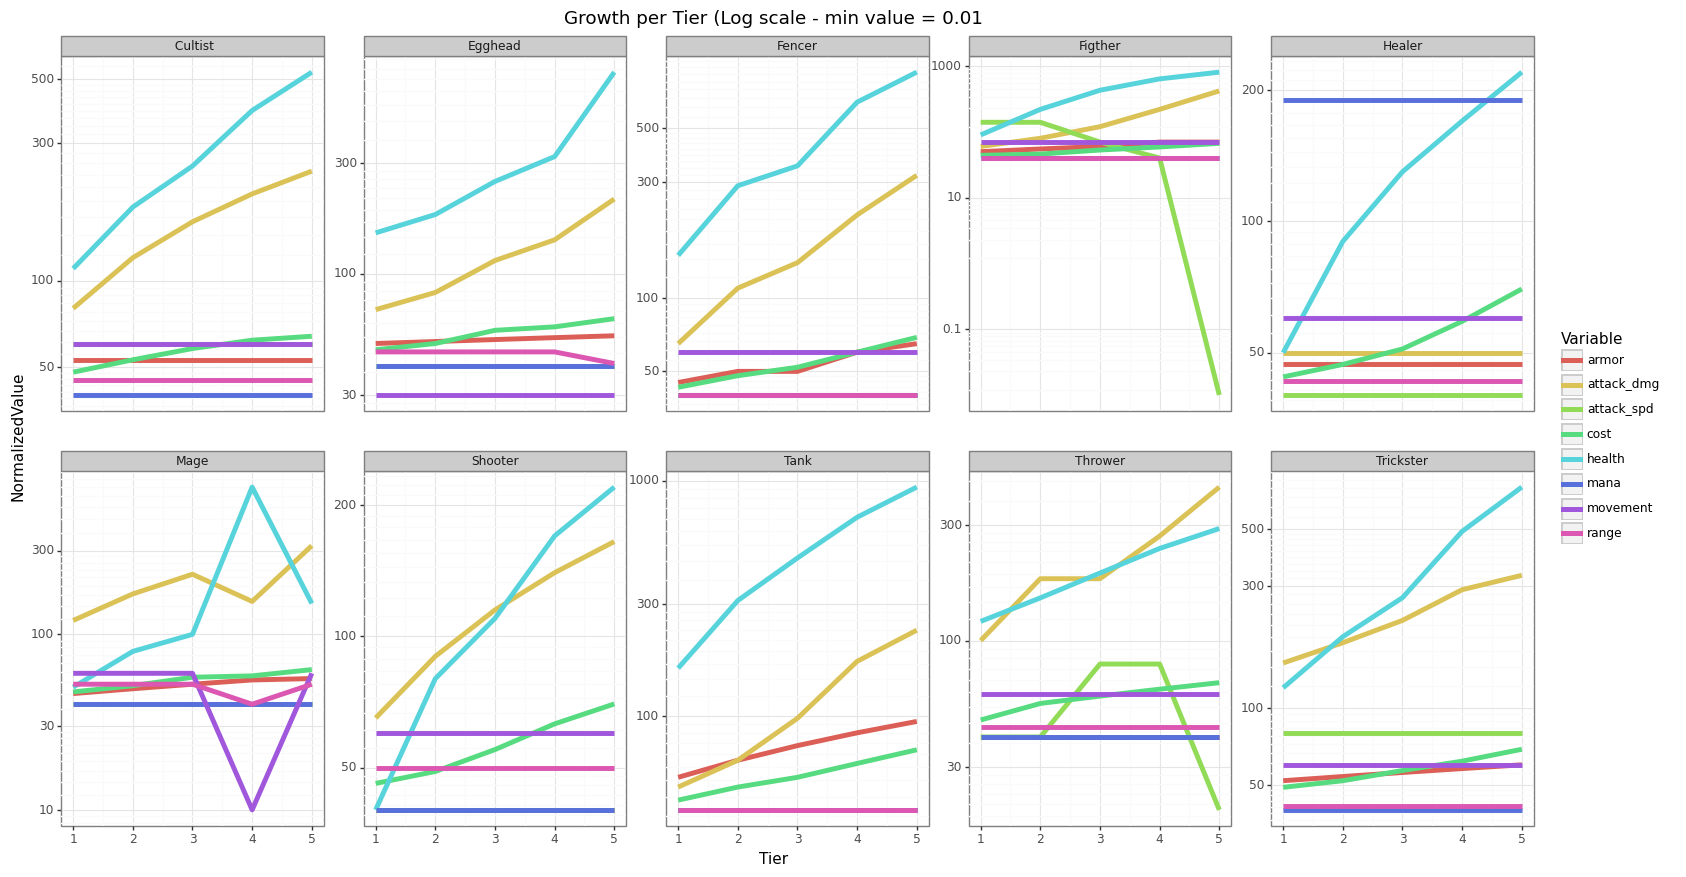

<ggplot: (8790451841461)>

In [25]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_stats.assign(NormalizedValue = dframe_stats["value"] - dframe_stats["value"].min() + 0.01 )) + 
 p9.aes(x = "Tier", y = "NormalizedValue", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", ncol=5, scales="free_y") +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Growth per Tier (Log scale - min value = 0.01")
)

display( gg_unit_trend + p9.scale_y_log10() )

### Cost normalized

In [44]:
dframe_costs = dframe_stats.query("Variable == 'cost'").drop_duplicates().rename(columns={'value':'unit_cost'})[["Class", "Tier", "unit_cost"]]
dframe_costs.sample(3)

,Class,Tier,unit_cost
55,Shooter,1,6.0
7,Tank,3,15.0
7,Tank,2,10.0


In [50]:
dframe_normcost = pd.merge( dframe_stats,
          dframe_costs,         
         on = ["Class", "Tier"]
        )

dframe_normcost = dframe_normcost.assign(NormalizedValue = dframe_normcost["value"] / dframe_normcost["unit_cost"]) 

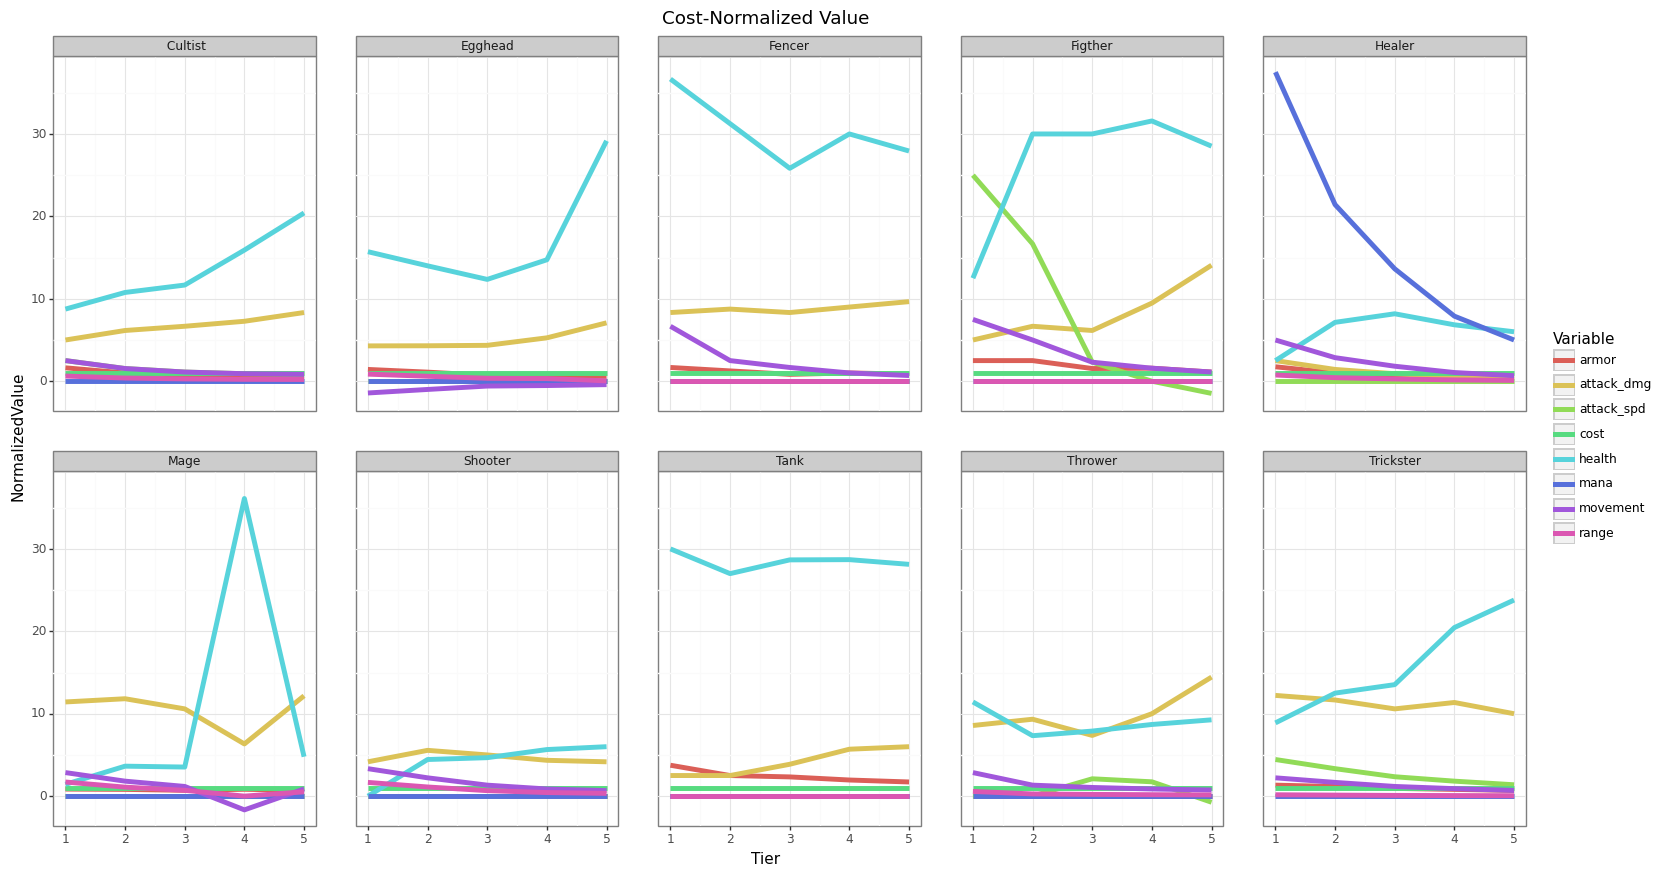

<ggplot: (8790453183217)>

In [54]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_normcost) + 
 p9.aes(x = "Tier", y = "NormalizedValue", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", nrow=2) +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Cost-Normalized Value")
)

display(gg_unit_trend)

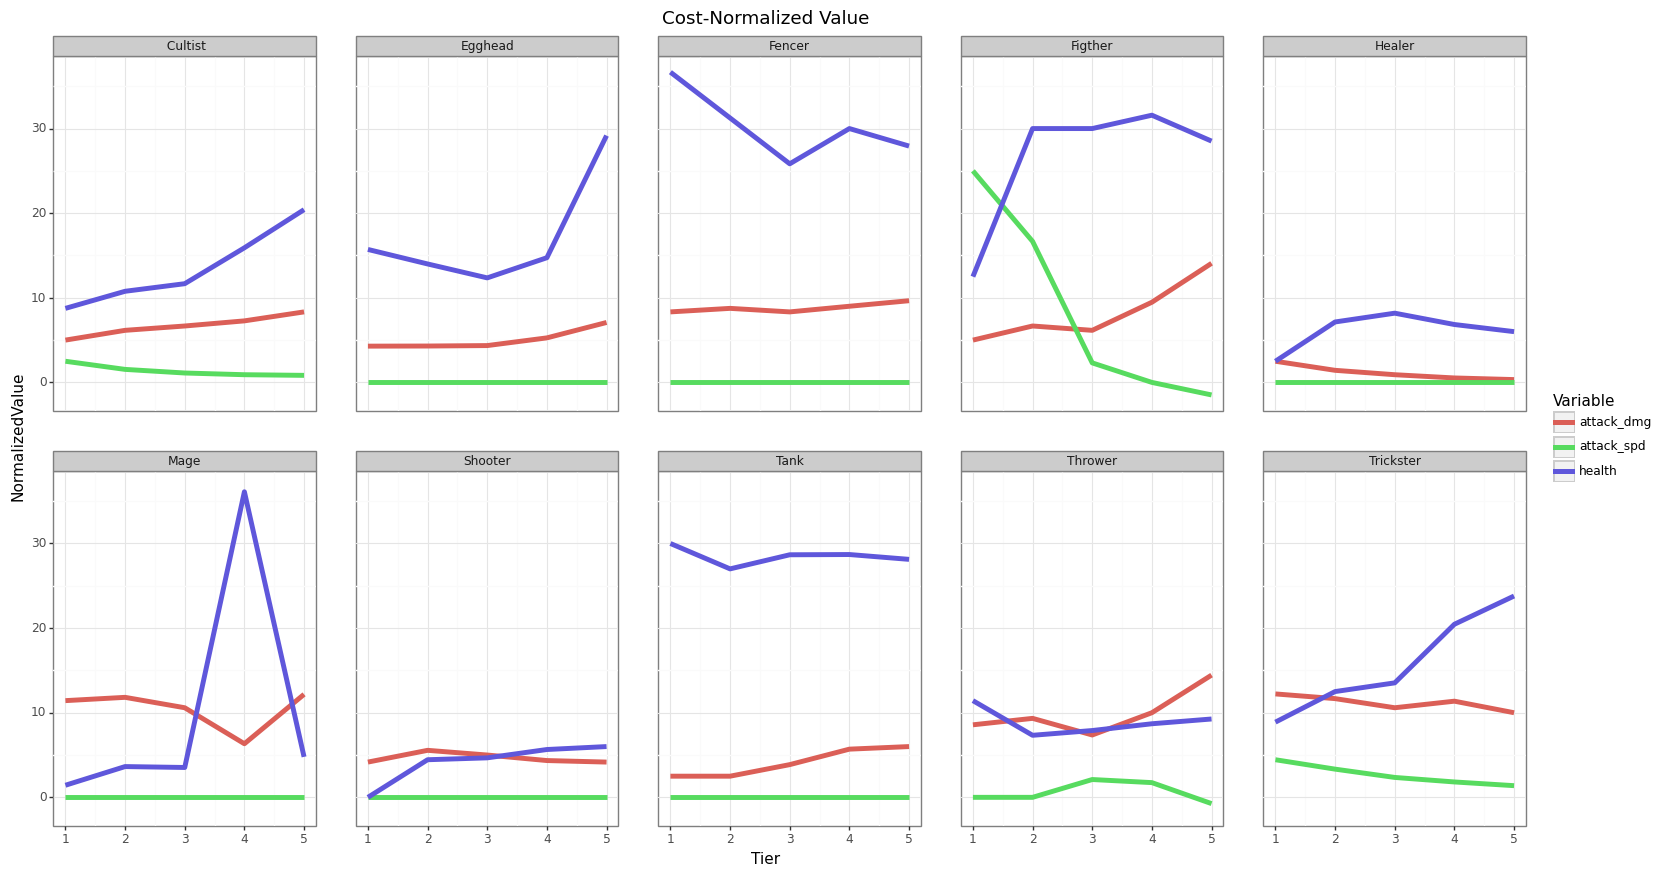

<ggplot: (8790453161855)>

In [100]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_normcost.query("Variable == 'health' or Variable == 'attack_dmg' or Variable == 'attack_spd'")) + 
 p9.aes(x = "Tier", y = "NormalizedValue", color = "Variable") +
 p9.geom_line(size=2) +
 p9.facet_wrap("Class", nrow=2) +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Cost-Normalized Value")
)

display(gg_unit_trend)

### Damage speed

TODO: This focuses on increases, could probably include base newb stats, or bonus levels.
Also it's not really `dps`, it's more base damage multiplied by speed increase as  a general score.

In [84]:
dframe_dps =\
pd.merge(
    dframe_normcost.query("Variable == 'attack_dmg'").set_index(["Class", "Tier", "unit_cost"])[["value"]].rename(columns={'value' : 'attack_dmg'}),
    dframe_normcost.query("Variable == 'attack_spd'").set_index(["Class", "Tier", "unit_cost"])[["value"]].rename(columns={'value' : 'attack_spd'}), left_index=True, right_index=True
)

In [93]:
dframe_dps["dps"] = (dframe_dps["attack_dmg"] * (dframe_dps["attack_spd"]/100 + 1.0))
dframe_dps["dps_normalized"] = dframe_dps["dps"] / dframe_dps.reset_index()["unit_cost"].values
dframe_dps

,,,attack_dmg,attack_spd,dps,dps_normalized
Class,Tier,unit_cost,,,,
Tank,1,4.0,10.0,0.0,10.0,2.500000
Fencer,1,3.0,25.0,0.0,25.0,8.333333
Trickster,1,9.0,110.0,40.0,154.0,17.111111
Figther,1,4.0,20.0,100.0,40.0,10.000000
Healer,1,4.0,10.0,0.0,10.0,2.500000
Thrower,1,7.0,60.0,0.0,60.0,8.571429
Shooter,1,6.0,25.0,0.0,25.0,4.166667
Cultist,1,8.0,40.0,20.0,48.0,6.000000
Mage,1,7.0,80.0,0.0,80.0,11.428571


/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


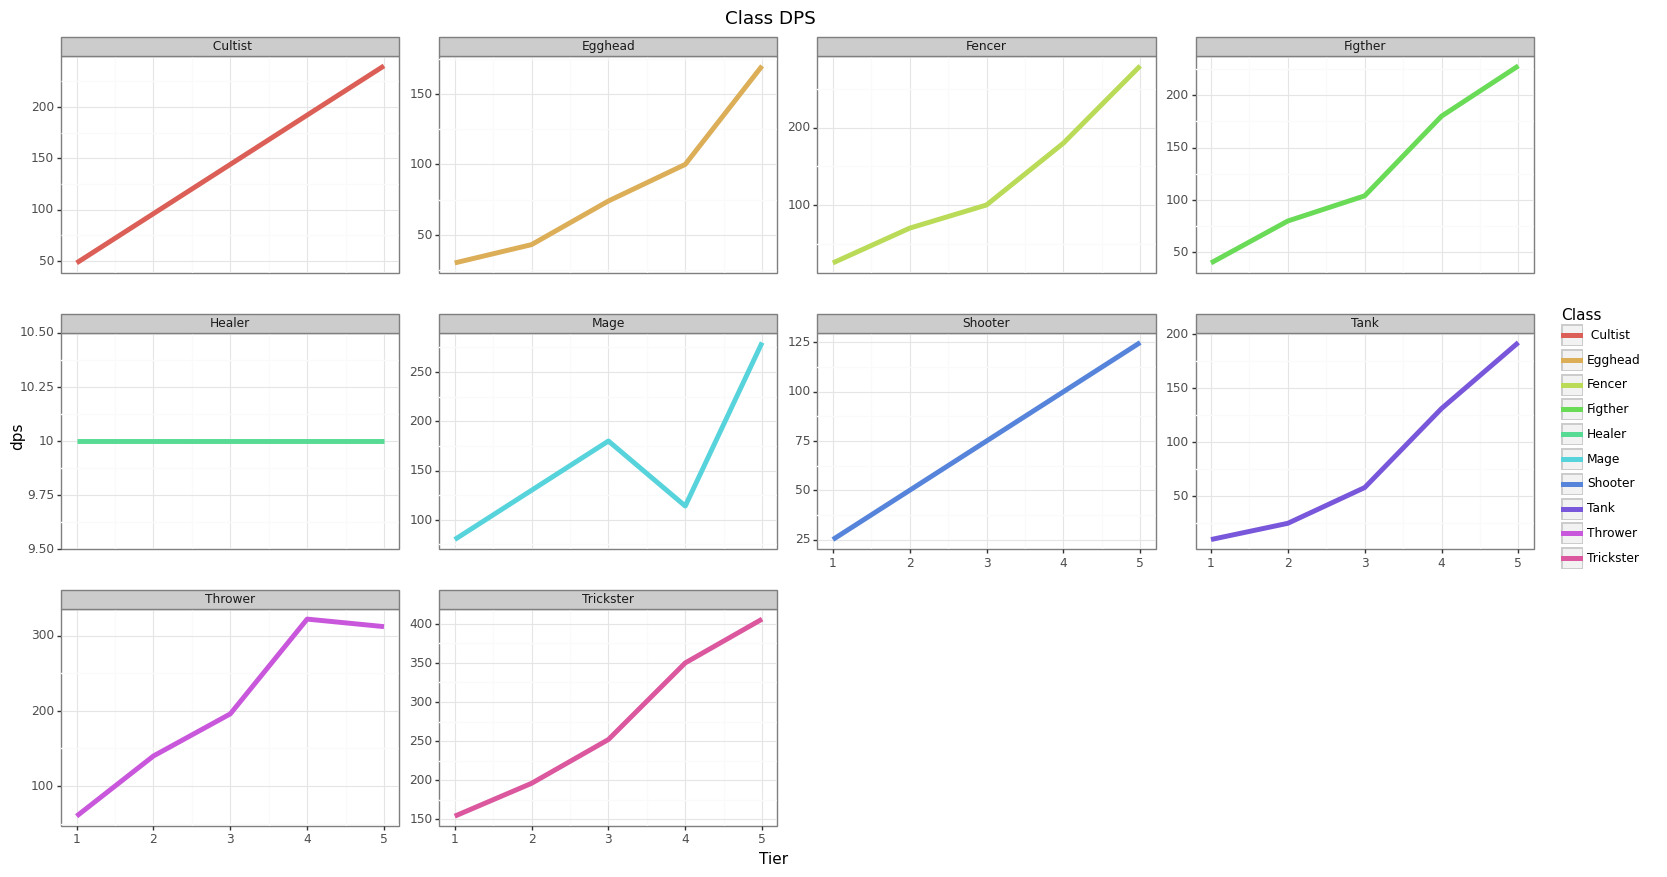

<ggplot: (8790453064970)>

In [95]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_dps.reset_index()) + 
 p9.aes(x = "Tier", y = "dps", color = "Class") +
 p9.geom_line(size=2) + 
 p9.facet_wrap("Class", scales="free_y") +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Class DPS ")
)

display(gg_unit_trend)

/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


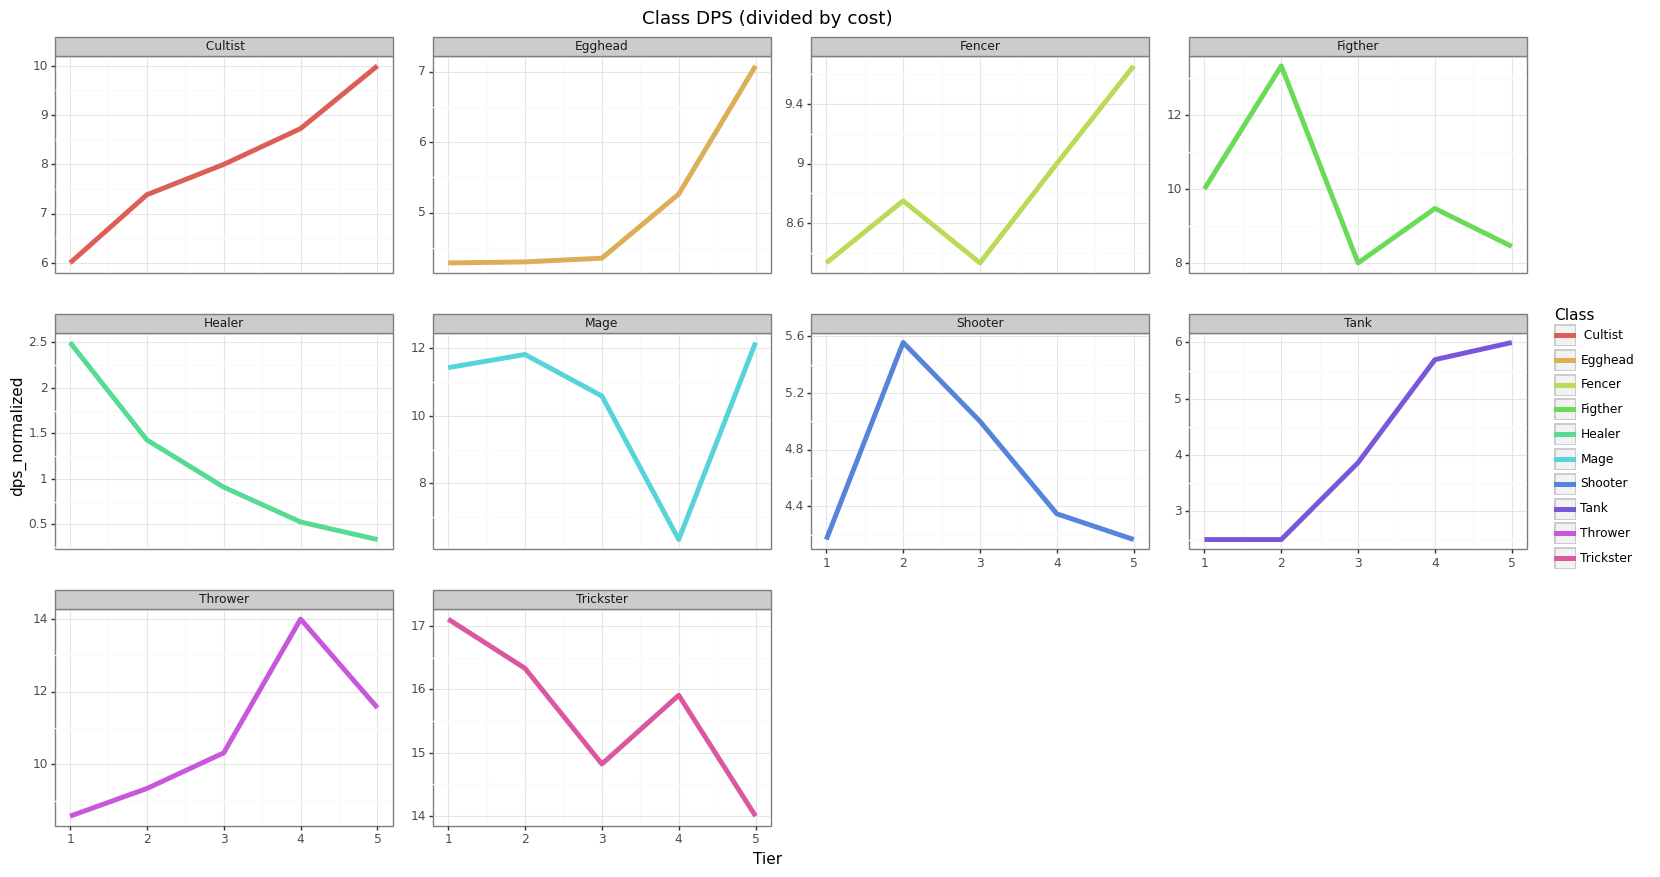

<ggplot: (8790445417223)>

In [94]:
p9.options.figure_size = 19,10

gg_unit_trend = (p9.ggplot(dframe_dps.reset_index()) + 
 p9.aes(x = "Tier", y = "dps_normalized", color = "Class") +
 p9.geom_line(size=2) + 
 p9.facet_wrap("Class", scales="free_y") +
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.4) +
 p9.ggtitle("Class DPS (divided by cost)")
)

display(gg_unit_trend)

### Growth within stats

For this visualization we're focusing on the individual statistics for comparison between classes.

/home/z/miniconda3/envs/despot-stats/lib/python3.8/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


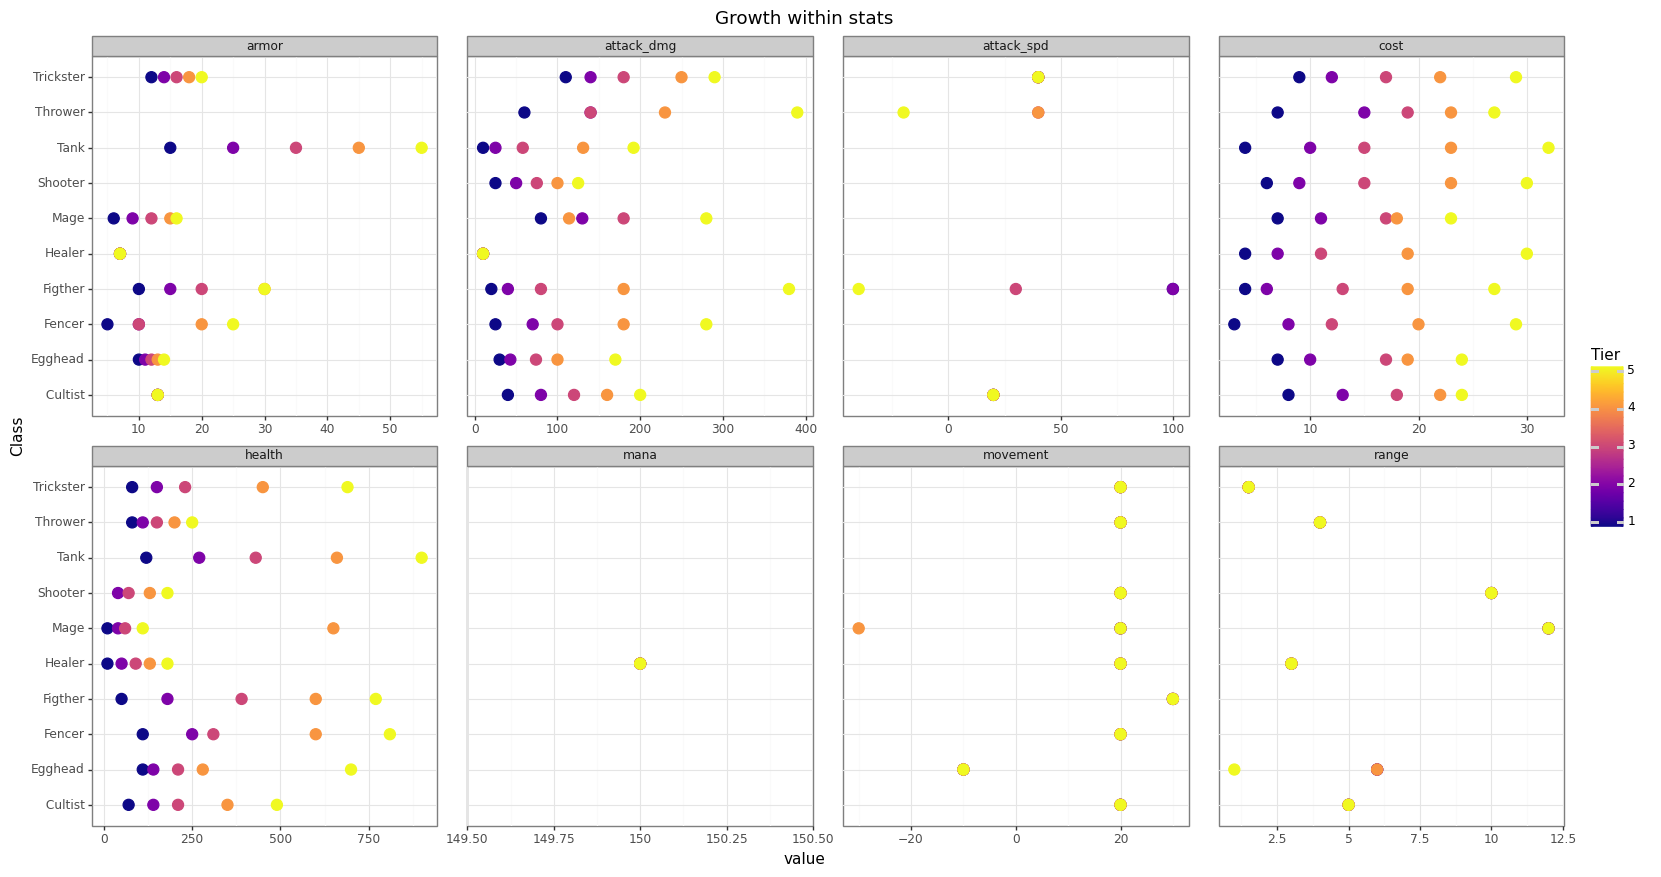

<ggplot: (8790453656905)>

In [9]:
p9.options.figure_size = 19,10

(p9.ggplot(dframe_stats.query("value != 0") ) + 
 p9.aes(x = "value", y = "Class", color = "Tier") +
 p9.geom_point(size=4) +
 p9.facet_wrap("Variable", nrow=2, scales="free_x") + 
 p9.theme_bw() +
 p9.theme(panel_spacing = 0.3) +
 p9.ggtitle("Growth within stats") +
 p9.scale_color_continuous("plasma") 
)